### Objective

In this notebook, we develop a PI-DeepONet model that tackles inverse problems. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = 0.5 \cdot u(t) + 0.5, \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$. Our goal is to calibrate u(t) given the observed s(t).

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [2]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)
    
    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate
    
    Outputs:
    --------
    u_sample: generated u(·) profiles
    """
    
    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
    
    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior
        
    return u_sample

In [ ]:
# Inspect generated data 
length_scale = 0.4
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [3]:
def generate_dataset(N, length_scale, a, b, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    a, b: unknown ODE parameters that need to be calibrated
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    
    # Create random fields
    random_field = create_samples(length_scale, N)
    
    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: a*np.interp(var_t, t.flatten(), random_field[i, :])+b, 
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
        
    return X, y

In [4]:
# Define true parameter values
a, b = 0.5, 0.5

# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train, a, b, ODE_solve=True)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test, a, b, ODE_solve=True)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_forward_test, y_forward_test = generate_dataset(N_test, length_scale_test, a, b, ODE_solve=True)
X_inverse_test, y_inverse_test = generate_dataset(N_test, length_scale_test, a, b, ODE_solve=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 771.09it/s]


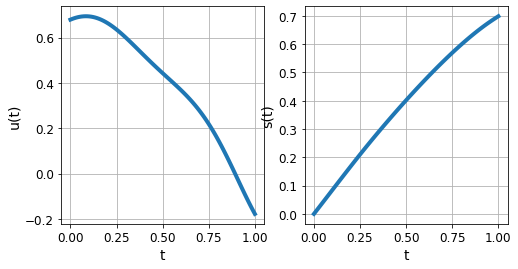

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_forward_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_forward_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

#### Separate initial condition and collocation points

In [6]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
y_train_ini = tf.convert_to_tensor(y_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Data type conversion
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

# Scaling 
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [7]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define a custom layer for hosting unknown parameters

In [8]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable
        
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed DeepONet

In [9]:
def create_model(mean, var, a_init=None, b_init=None, trainable=None, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """
    
    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)   
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)
    
    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)
    
    # Add the bias
    dot_product_with_bias = BiasLayer()(dot_product)

    # Add a & b trainable parameters
    output = ParameterLayer(a_init, b_init, trainable)(dot_product_with_bias)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model   

#### ODE loss

In [10]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})
    
    # Calculate gradients
    ds_dt = tape.gradient(s, t)
    
    # ODE residual
    ODE_residual = ds_dt - model.layers[-1].a*u_t - model.layers[-1].b
    
    return ODE_residual

#### Gradient descent step

In [11]:
@tf.function
def train_step(X, y, X_init, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)
        
        # Data loss
        y_pred_data = model({"forcing": X[:, 1:-1], "time": X[:, :1]})

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define Loss Tracking class

In [12]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [13]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training: create the surrogate model

In [14]:
# Set up training configurations
n_epochs = 200
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(0.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# True values for unknown parameters
a, b = 0.5, 0.5

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):
    
    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var, a_init=a, b_init=b, trainable=False)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_init, _), (X, y) in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X, y, X_init, 
                                                                            IC_weight, ODE_weight,
                                                                            data_weight, PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PI_DeepONet.layers[-1].a.numpy())
        b_list.append(PI_DeepONet.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_ODE+val_IC})
        val_loss_hist.append(val_ODE+val_IC)

        
        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size) 

Epoch 1:
IC=2.4039e-02,               ODE=8.5957e-02,               data=3.5792e-02,               total_loss=1.1000e-01
val_IC: 1.6762e-03, val_ODE: 1.5651e-02, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.052971228093265786
Epoch 2:
IC=1.0202e-03,               ODE=1.0871e-02,               data=2.0498e-03,               total_loss=1.1891e-02
val_IC: 1.0980e-03, val_ODE: 8.3637e-03, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.03512323820476852
Epoch 3:
IC=6.7429e-04,               ODE=7.0104e-03,               data=1.2190e-03,               total_loss=7.6847e-03
val_IC: 6.4780e-04, val_ODE: 6.1267e-03, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.032128307834118526
Epoch 4:
IC=5.3315e-04,               ODE=5.3533e-03,               data=8.2423e-04,               total_loss=5.8864e-03
val_IC: 4.3271e-04, val_ODE: 4.9747e-03, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.0270868775570059
Epoch 5:
IC=3.9520e-04,               ODE=4.3200e-03,               data=6.0522e-04,               total_loss=4.715

IC=3.3250e-05,               ODE=4.6815e-04,               data=4.7988e-05,               total_loss=5.0140e-04
val_IC: 1.8445e-05, val_ODE: 4.4428e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.005192004210510483
Epoch 39:
IC=5.0602e-05,               ODE=5.8533e-04,               data=7.6072e-05,               total_loss=6.3593e-04
val_IC: 2.8825e-05, val_ODE: 3.4515e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.008294969411813732
Epoch 40:
IC=5.8057e-05,               ODE=4.6991e-04,               data=8.4877e-05,               total_loss=5.2797e-04
val_IC: 2.6944e-05, val_ODE: 5.6045e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.008586603056422924
Epoch 41:
IC=4.1828e-05,               ODE=5.8099e-04,               data=7.0977e-05,               total_loss=6.2282e-04
val_IC: 4.2579e-05, val_ODE: 4.9380e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.007727772485809015
Epoch 42:
IC=3.1827e-05,               ODE=4.1624e-04,               data=5.1232e-05,               total_loss=4.4807e

IC=1.2607e-05,               ODE=1.4687e-04,               data=2.7400e-05,               total_loss=1.5948e-04
val_IC: 8.5811e-06, val_ODE: 1.2542e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.0055505285261718915
Epoch 76:
IC=1.7229e-05,               ODE=3.3507e-04,               data=4.5139e-05,               total_loss=3.5230e-04
val_IC: 2.1224e-04, val_ODE: 1.5177e-03, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.012736233537957562
Epoch 77:
IC=9.2281e-05,               ODE=4.3840e-04,               data=1.1828e-04,               total_loss=5.3068e-04
val_IC: 2.0740e-05, val_ODE: 1.1422e-04, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.006004511344686425
Epoch 78:
IC=1.5693e-05,               ODE=1.2141e-04,               data=3.0249e-05,               total_loss=1.3710e-04
val_IC: 6.3819e-06, val_ODE: 9.1411e-05, lr: 1.00e-03

a: [0.5], b: [0.5]
RMSE: 0.004773465843824245
Epoch 79:
IC=1.0136e-05,               ODE=1.4613e-04,               data=2.7535e-05,               total_loss=1.5627

IC=5.3985e-06,               ODE=6.1584e-05,               data=1.1085e-05,               total_loss=6.6982e-05
val_IC: 5.6682e-06, val_ODE: 5.3434e-05, lr: 5.00e-04

a: [0.5], b: [0.5]
RMSE: 0.0037405426344996745
Epoch 113:
IC=3.7443e-06,               ODE=8.2832e-05,               data=1.0272e-05,               total_loss=8.6576e-05
val_IC: 5.6959e-06, val_ODE: 9.6660e-05, lr: 5.00e-04

a: [0.5], b: [0.5]
RMSE: 0.002881317262008223
Epoch 114:
IC=8.0475e-06,               ODE=8.7279e-05,               data=1.8071e-05,               total_loss=9.5327e-05
val_IC: 5.6529e-06, val_ODE: 6.7319e-05, lr: 5.00e-04

a: [0.5], b: [0.5]
RMSE: 0.0025627054607779156
Epoch 115:
IC=5.4673e-06,               ODE=6.5710e-05,               data=1.1845e-05,               total_loss=7.1177e-05
val_IC: 4.7849e-06, val_ODE: 7.2399e-05, lr: 5.00e-04

a: [0.5], b: [0.5]
RMSE: 0.004359442669577416
Epoch 116:
IC=3.7213e-06,               ODE=6.4898e-05,               data=1.0439e-05,               total_loss=6

IC=1.8773e-06,               ODE=4.5019e-05,               data=5.6989e-06,               total_loss=4.6896e-05
val_IC: 1.2575e-06, val_ODE: 3.7171e-05, lr: 2.50e-04

a: [0.5], b: [0.5]
RMSE: 0.0018744095652011294
Epoch 150:
IC=1.3823e-06,               ODE=3.7685e-05,               data=3.9375e-06,               total_loss=3.9067e-05
val_IC: 2.4255e-06, val_ODE: 5.5769e-05, lr: 2.50e-04

a: [0.5], b: [0.5]
RMSE: 0.0021076471357608702
Epoch 151:
IC=1.4219e-06,               ODE=4.3213e-05,               data=4.9209e-06,               total_loss=4.4635e-05
val_IC: 1.4653e-06, val_ODE: 3.1120e-05, lr: 2.50e-04

a: [0.5], b: [0.5]
RMSE: 0.0019506728544235483
Epoch 152:
IC=2.6254e-06,               ODE=3.9905e-05,               data=5.4011e-06,               total_loss=4.2531e-05
val_IC: 1.3525e-06, val_ODE: 3.2875e-05, lr: 2.50e-04

a: [0.5], b: [0.5]
RMSE: 0.0013496147750851433
Epoch 153:
IC=2.0580e-06,               ODE=4.3341e-05,               data=5.2094e-06,               total_loss

IC=7.0850e-07,               ODE=2.8663e-05,               data=2.1871e-06,               total_loss=2.9371e-05
val_IC: 1.2083e-06, val_ODE: 2.4589e-05, lr: 1.25e-04

a: [0.5], b: [0.5]
RMSE: 0.0014562007357653906
Epoch 187:
IC=7.8309e-07,               ODE=2.8816e-05,               data=2.2991e-06,               total_loss=2.9599e-05
val_IC: 5.2915e-07, val_ODE: 2.6273e-05, lr: 1.25e-04

a: [0.5], b: [0.5]
RMSE: 0.0011373159464661033
Epoch 188:
IC=9.8668e-07,               ODE=2.8850e-05,               data=2.3235e-06,               total_loss=2.9836e-05
val_IC: 1.3258e-06, val_ODE: 2.9779e-05, lr: 1.25e-04

a: [0.5], b: [0.5]
RMSE: 0.0013234370387991646
Epoch 189:
IC=7.1857e-07,               ODE=2.7583e-05,               data=2.0909e-06,               total_loss=2.8301e-05
val_IC: 1.8327e-06, val_ODE: 2.7417e-05, lr: 1.25e-04

a: [0.5], b: [0.5]
RMSE: 0.0014732175770015995
Epoch 190:
IC=4.3074e-07,               ODE=2.3974e-05,               data=1.3371e-06,               total_loss

In [ ]:
# History for loss
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

#### Inverse calibration: native TensorFlow

In [ ]:
@tf.function
def gradient_u(model, u, s_target):
    """ Calculate the gradients of objective function with respect to u(·).
    
    Args:
    ----
    model: the trained PI-DeepONet model
    u: u()
    s_target: the observed s()
    
    
    Outputs:
    --------
    obj: objective function
    gradients: calculated gradients
    """
    
    with tf.GradientTape() as tape:
        tape.watch(u)

        # Initial condition prediction
        y_pred_IC = model({"forcing": u, "time": 0})
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))

        # ODE residual
        ODE_residual = ODE_residual_calculator(t=tf.reshape(tf.linspace(0.0, 1.0, 100), (-1, 1)), 
                                               u=tf.tile(tf.reshape(u, (1, -1)), [100, 1]), 
                                               u_t=tf.reshape(u, (-1, 1)), model=model)
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Predict s() with the current u()
        y_pred = model({"forcing": tf.tile(tf.reshape(u, (1, -1)), [100, 1]), 
                        "time": tf.reshape(tf.linspace(0.0, 1.0, 100), (-1, 1))})

        # Data loss
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(s_target, y_pred))

        # Total loss
        obj = IC_loss + ODE_loss + data_loss

    # Gradient descent
    gradients = tape.gradient(obj, u)
    
    return obj, gradients

In [ ]:
def optimize_u(model, initial_u, s_target, learning_rate=5e-3, opt_steps=10000):
    """ Determine u() that generates the observed s().
    
    Args:
    ----
    model: the trained PI-DeepONet model
    initial_u: initial guess for u()
    s_target: the observed s()
    learning_rate: learning rate for the optimizer
    opt_steps: number of optimization iterations
    
    
    Outputs:
    --------
    u: the optimized u()
    u_hist: intermedian u results
    objective_func_hist: value history of the objective function
    """
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Setup u() and empty list for storing results
    u_var = tf.Variable(initial_u, dtype=tf.float32)
    objective_func_hist = []
    u_hist = []
    
    for step in range(opt_steps):
        
        # Calculate gradients
        obj, gradients = gradient_u(model, u_var, s_target)
        
        # Gradient descent
        optimizer.apply_gradients([(gradients, u_var)])
        
        # Record results
        objective_func_hist.append(obj.numpy())
        u_hist.append(u_var.numpy())
        
        # Show progress
        if step % 500 == 0:
            print(f'Step {step} ==> Objective function = {obj.numpy()}')
            
    # Optimized u()
    u = u_var.numpy()
    
    return u, objective_func_hist, u_hist

We randomly select one s() profile and see if our approach can identified the correct u() that generated the given s().

In [ ]:
sample_id = 25
initial_u = np.zeros(100, dtype=np.float32)
s_target = y_inverse_test[sample_id*100:(sample_id+1)*100, :]
opt_u, objective_func_hist, u_hist = optimize_u(PI_DeepONet, initial_u, s_target, learning_rate=0.005, opt_steps=20000)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(range(len(objective_func_hist)), objective_func_hist)
ax.set_title('Objective Function Evolution', fontsize=14)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss_inverse.png', bbox_inches='tight', pad_inches=0, transparent=True)

We can plot the convergence history

In [ ]:
%matplotlib inline
indices = [0, 3999, 7999, 11999, 15999, 19999]
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
for i in range(6):
    ax = axs[i//3, i%3]
    ax.plot(np.linspace(0, 1, 100), X_inverse_test[sample_id*100, 1:-1], lw=4, c='r', label='Ground truth')
    ax.plot(np.linspace(0, 1, 100), u_hist[indices[i]], lw=4, label='Calibration')
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.set_title(f'Iteration {indices[i]+1}', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig('u_history.png', bbox_inches='tight', transparent=True)

Forward simulation: predicting s() given the calibrated u()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(np.linspace(0, 1, 100), opt_u, label='Calibration', lw=4)
ax[0].plot(np.linspace(0, 1, 100), X_inverse_test[sample_id*100, 1:-1], label='Ground truth', lw=4)
ax[0].set_title('u(t)', fontsize=14)


# Inference pipeline
dataset = np.concatenate([np.linspace(0, 1, 100).reshape(-1, 1), np.tile(opt_u, (100, 1))], axis=1)
pred = PI_DeepONet.predict({"forcing": dataset[:, 1:], "time": dataset[:, :1]}, batch_size=12800)
ax[1].plot(np.linspace(0, 1, 100), pred.flatten(), label='Calibration', lw=4)

# ODE solver
t = np.linspace(0, 1, 100)
sol = solve_ivp(lambda var_t, var_s: a*np.interp(var_t, t, opt_u)+b, 
                t_span=[0, 1], y0=[0], t_eval=t, method='RK45')
ax[1].plot(np.linspace(0, 1, 100), sol.y[0], label='ODE Solver', lw=4)

# Ground truth
ax[1].plot(np.linspace(0, 1, 100), y_target.flatten(), label='Ground truth', lw=4)

ax[1].set_title('s(t)', fontsize=14)

for axs in ax:
    axs.legend()
    axs.grid(True)
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.tight_layout()
plt.savefig('s_prediction.png', bbox_inches='tight', transparent=True)

We further test other u() profiles to see if the approach works properly

In [ ]:
opt_u_list = []
sample_id_list = []
for i in range(6):
    sample_id = np.random.randint(0, 100)
    print(f"Start {i+1} iteration, picked {sample_id}-th sample!")
    initial_u = np.zeros(100, dtype=np.float32)
    s_target = y_inverse_test[sample_id*100:(sample_id+1)*100, :]
    opt_u, _, _ = optimize_u(PI_DeepONet, initial_u, s_target, learning_rate=0.005, opt_steps=20000)
    opt_u_list.append(opt_u)
    sample_id_list.append(sample_id)

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
sample_id_list = [13, 85, 73, 28, 51, 16]
for i in range(6):
    ax = axs[i//3, i%3]

    ax.plot(np.linspace(0, 1, 100), opt_u_list[i], label='Calibration', lw=4)
    ax.plot(np.linspace(0, 1, 100), X_inverse_test[sample_id_list[i]*100, 1:-1], label='Ground truth', lw=4)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.set_title(f"{sample_id_list[i]}-th sample")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.tight_layout()
plt.savefig('s_prediction_batch.png', bbox_inches='tight', transparent=True)

#### Inverse calibration: L-BFGS

In [18]:
def obj_fn(u_var, model, s_target, convert_to_numpy=False):
    """ Calculate objective function.
    
    Args:
    ----
    u_var: u()
    model: the trained PI-DeepONet model
    s_target: the observed s()
    convert_to_numpy: boolean, indicate whether to convert the calculated objective value to numpy
    
    
    Outputs:
    --------
    obj: objective function
    """
    
    # Initial condition prediction
    y_pred_IC = model({"forcing": u_var, "time": 0})

    # ODE residual
    ODE_residual = ODE_residual_calculator(t=tf.reshape(tf.linspace(0.0, 1.0, 100), (-1, 1)), 
                                           u=tf.tile(tf.reshape(u_var, (1, -1)), [100, 1]), 
                                           u_t=tf.cast(tf.reshape(u_var, (-1, 1)), tf.float32), model=model)

    # Predict the output with the current inputs
    y_pred = model({"forcing": tf.tile(tf.reshape(u_var, (1, -1)), [100, 1]), 
                    "time": tf.reshape(tf.linspace(0.0, 1.0, 100), (-1, 1))})

    # Compute the data loss
    data_loss = tf.reduce_mean(keras.losses.mean_squared_error(s_target, y_pred))

    # Calculate other losses
    IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
    ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

    # Obj function
    obj = IC_loss + ODE_loss + data_loss
    obj = obj if not convert_to_numpy else obj.numpy().astype(np.float64)
    
    return obj

In [19]:
from scipy.optimize import minimize

# Define the objective function
def obj_fn_numpy(u_var, model, s_target):
    return obj_fn(u_var, model, s_target, convert_to_numpy=True)

def obj_fn_tensor(u_var, model, s_target):
    return obj_fn(u_var, model, s_target, convert_to_numpy=False)

def grad_fn(u, model, s_target):
    u_var = tf.Variable(u, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(u_var)
        obj = obj_fn_tensor(u_var, model, s_target)
        
    # Calculate gradients
    grads = tape.gradient(obj, u_var)
    
    return grads.numpy().astype(np.float64)


def optimize_u_LBFGS(model, initial_u, s_target, opt_steps=1000):
    """Optimize the inputs to a model to achieve a target output.
    
    Args:
    ----
    model: the trained PI-DeepONet model
    initial_u: initial guess for u()
    s_target: the observed s()
    opt_steps: number of optimization iterations
    
    Outputs:
    --------
    res.x: the optimized u
    """
    
    # L-BFGS optimizer 
    res = minimize(fun=obj_fn_numpy, x0=initial_u, args=(model, s_target),
                   method='L-BFGS-B', jac=grad_fn, options={'maxiter': opt_steps, 'disp': True})
    
    return res.x

We randomly select one s() profile and see if our approach can identified the correct u() that generated the given s().

In [27]:
sample_id = 15
initial_u = np.zeros(100, dtype=np.float32)
s_target = y_inverse_test[sample_id*100:(sample_id+1)*100, :]
opt_u_LBFGS = optimize_u_LBFGS(PI_DeepONet, initial_u, s_target, opt_steps=1000)

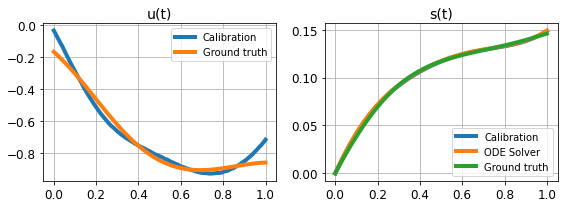

In [28]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(np.linspace(0, 1, 100), opt_u_LBFGS, label='Calibration', lw=4)
ax[0].plot(np.linspace(0, 1, 100), X_inverse_test[sample_id*100, 1:-1], label='Ground truth', lw=4)
ax[0].set_title('u(t)', fontsize=14)

# Inference pipeline
dataset = np.concatenate([np.linspace(0, 1, 100).reshape(-1, 1), np.tile(opt_u_LBFGS, (100, 1))], axis=1)
pred = PI_DeepONet.predict({"forcing": dataset[:, 1:], "time": dataset[:, :1]}, batch_size=12800)
ax[1].plot(np.linspace(0, 1, 100), pred.flatten(), label='Calibration', lw=4)

# ODE solver
t = np.linspace(0, 1, 100)
sol = solve_ivp(lambda var_t, var_s: a*np.interp(var_t, t, opt_u_LBFGS)+b, 
                t_span=[0, 1], y0=[0], t_eval=t, method='RK45')
ax[1].plot(np.linspace(0, 1, 100), sol.y[0], label='ODE Solver', lw=4)

# Ground truth
ax[1].plot(np.linspace(0, 1, 100), s_target.flatten(), label='Ground truth', lw=4)
ax[1].set_title('s(t)', fontsize=14)

for axs in ax:
    axs.legend()
    axs.grid(True)
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.tight_layout()
plt.savefig('s_prediction_L_BFGS.png', bbox_inches='tight', transparent=True)

We further test other u() profiles to see if the approach works properly

In [34]:
opt_u_list = []
sample_id_list = []
for i in range(6):
    sample_id = np.random.randint(0, 100)
    print(f"Start {i+1} iteration, picked {sample_id}-th sample!")
    
    initial_u = np.zeros(100, dtype=np.float32)
    s_target = y_inverse_test[sample_id*100:(sample_id+1)*100, :]
    opt_u = optimize_u_LBFGS(PI_DeepONet, initial_u, s_target, opt_steps=1000)
    opt_u_list.append(opt_u)
    sample_id_list.append(sample_id)

Start 1 iteration, picked 0-th sample!
Start 2 iteration, picked 95-th sample!
Start 3 iteration, picked 2-th sample!
Start 4 iteration, picked 17-th sample!
Start 5 iteration, picked 1-th sample!
Start 6 iteration, picked 89-th sample!


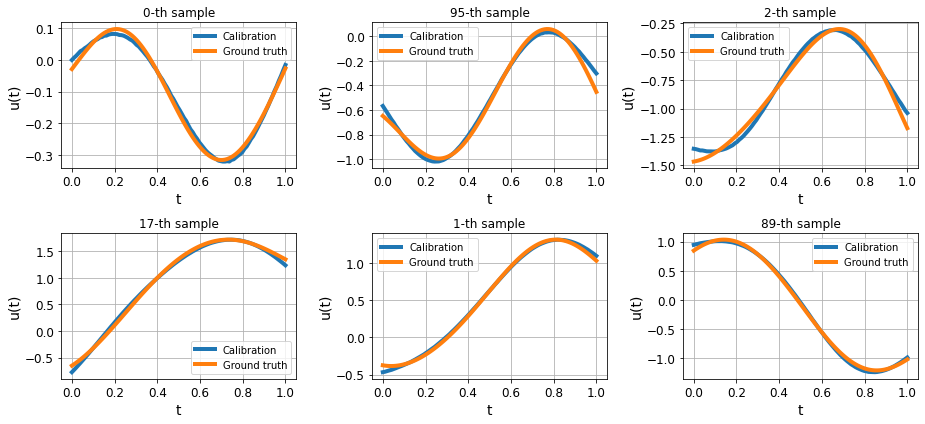

In [35]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
for i in range(6):
    ax = axs[i//3, i%3]

    ax.plot(np.linspace(0, 1, 100), opt_u_list[i], label='Calibration', lw=4)
    ax.plot(np.linspace(0, 1, 100), X_inverse_test[sample_id_list[i]*100, 1:-1], label='Ground truth', lw=4)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.set_title(f"{sample_id_list[i]}-th sample")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.tight_layout()
plt.savefig('s_prediction_LBFGS_batch.png', bbox_inches='tight', transparent=True)